[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  1 of 1 completed


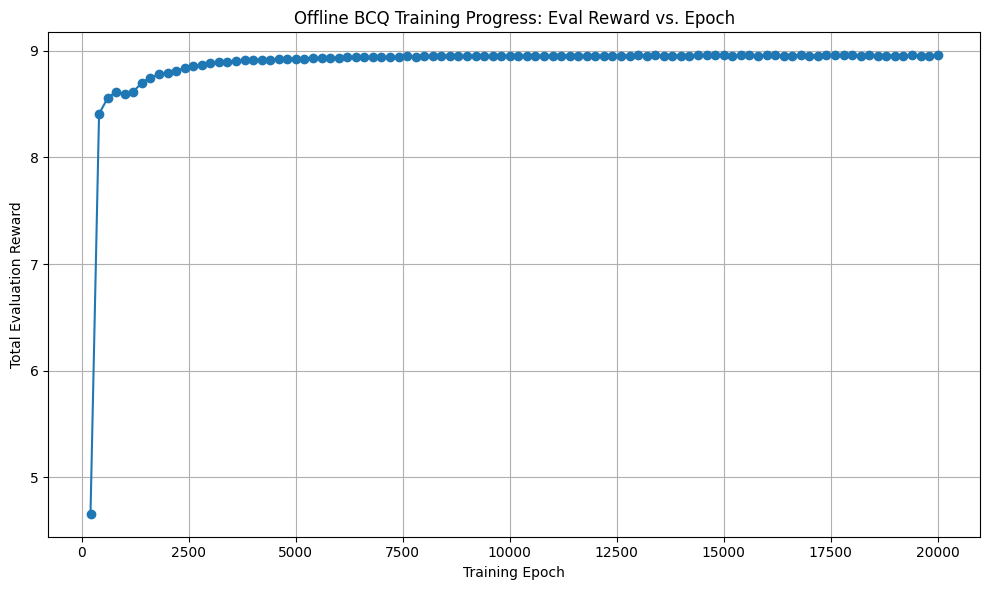

In [26]:
import datetime
import numpy as np
import pandas as pd
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from pandas_datareader import data as pdr

# ----------------------
# 0) DEVICE SETUP
# ----------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------------
# 1) HISTORICAL DATASET (expert)
# ----------------------
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class HistoricalDataset:
    def __init__(self, prices, divs, vols, irate,
                 window_size=30, transaction_cost=1e-4, initial_cash=10000):
        self.prices = prices.astype(np.float32)
        self.divs = divs.astype(np.float32)
        self.vols = vols.astype(np.float32)
        self.irate = irate.astype(np.float32)
        self.T, self.N = self.prices.shape
        self.window = window_size
        self.tc = transaction_cost
        self.initial_cash = initial_cash
        self.holdings = np.zeros((self.T, self.N), dtype=np.float32)
        self.cash = np.full(self.T, initial_cash, dtype=np.float32)
        self.actions = self._generate_expert_actions()

    def _generate_expert_actions(self):
        actions = np.zeros((self.T, self.N+1), dtype=np.float32)
        for t in range(self.window, self.T-1):
            returns = self.prices[t] / self.prices[t-self.window] - 1.0
            top_idx = np.argsort(-returns)[:5]
            w = np.zeros(self.N+1, np.float32)
            w[top_idx] = 0.8 / len(top_idx)
            w[-1] = 0.2
            actions[t] = w
            self._update_portfolio(t, w)
        return actions

    def _update_portfolio(self, t, action):
        prev_val = (self.holdings[t-1] * self.prices[t]).sum() + self.cash[t-1]
        alloc = action[:-1] * prev_val
        new_h = alloc / self.prices[t]
        new_c = action[-1] * prev_val
        cost = self.tc * np.abs(new_h - self.holdings[t-1]) @ self.prices[t]
        self.holdings[t] = new_h
        self.cash[t] = new_c - cost

    def _get_state(self, t):
        window = self.prices[t-self.window:t]
        mean_p, std_p = window.mean(axis=0), window.std(axis=0)+1e-6
        price_feat = (self.prices[t] - mean_p) / std_p

        mean_d, std_d = self.divs[:t].mean(axis=0), self.divs[:t].std(axis=0)+1e-6
        div_feat = (self.divs[t] - mean_d) / std_d

        mean_v, std_v = self.vols[:t].mean(axis=0), self.vols[:t].std(axis=0)+1e-6
        vol_feat = (self.vols[t] - mean_v) / std_v

        mean_i, std_i = self.irate[:t].mean(), self.irate[:t].std()+1e-6
        irate_feat = np.array([(self.irate[t] - mean_i) / std_i], np.float32)

        h = self.holdings[t-1] if t>0 else np.zeros(self.N, np.float32)
        c = np.array([self.cash[t-1] / self.initial_cash], np.float32) if t>0 else np.array([1.0], np.float32)

        return np.concatenate([price_feat, div_feat, vol_feat, irate_feat, h, c], axis=0)

    def _calculate_reward(self, t, action):
        prev_stock = (self.holdings[t-1] * self.prices[t]).sum()
        prev_total = prev_stock + self.cash[t-1]
        alloc_vals = action[:-1] * prev_total
        target_cash = action[-1] * prev_total
        new_h = alloc_vals / self.prices[t]
        cost = self.tc * np.abs(new_h - self.holdings[t-1]) @ self.prices[t]
        self.holdings[t] = new_h
        self.cash[t] = target_cash - cost

        new_stock = (self.holdings[t] * self.prices[t+1]).sum()
        new_total = new_stock + self.cash[t]
        port_ret = new_total / prev_total - 1.0
        market_ret = self.prices[t+1].mean() / self.prices[t].mean() - 1.0
        return (port_ret - market_ret) * 100.0

    def create_offline_dataset(self):
        data = []
        for t in range(self.window, self.T-1):
            s = self._get_state(t)
            a = self.actions[t]
            s2 = self._get_state(t+1)
            r = self._calculate_reward(t, a)
            done = (t == self.T-2)
            data.append(Transition(s, a, r, s2, done))
        return data

# ----------------------
# 2) REPLAY BUFFER
# ----------------------
class ReplayBuffer:
    def __init__(self, capacity): self.buffer = deque(maxlen=capacity)
    def push_batch(self, batch): self.buffer.extend(batch)
    def sample(self, batch_size):
        idx = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[i] for i in idx]
        return Transition(*zip(*batch))
    def __len__(self): return len(self.buffer)

# ----------------------
# 3) BCQ AGENT
# ----------------------
class BCQAgent:
    def __init__(self, state_dim, action_dim, device):
        self.device = device
        self.discount, self.tau = 0.995, 0.005
        self.q1 = self.build_mlp(state_dim+action_dim, 1).to(device)
        self.q2 = self.build_mlp(state_dim+action_dim, 1).to(device)
        self.q1_t = self.build_mlp(state_dim+action_dim, 1).to(device)
        self.q2_t = self.build_mlp(state_dim+action_dim, 1).to(device)
        self.hard_update(self.q1_t, self.q1)
        self.hard_update(self.q2_t, self.q2)
        self.bc_policy = self.build_mlp(state_dim, action_dim).to(device)
        self.opt_q = optim.Adam(list(self.q1.parameters()) + list(self.q2.parameters()), lr=3e-4)
        self.opt_pi = optim.Adam(self.bc_policy.parameters(), lr=3e-4)

    def build_mlp(self, inp, out, hid=256):
        return nn.Sequential(
            nn.Linear(inp, hid), nn.ReLU(),
            nn.Linear(hid, hid), nn.ReLU(),
            nn.Linear(hid, out)
        )

    def hard_update(self, tgt, src): tgt.load_state_dict(src.state_dict())

    def soft_update(self, tgt, src):
        for tp, sp in zip(tgt.parameters(), src.parameters()):
            tp.data.copy_(tp.data*(1-self.tau) + sp.data*self.tau)

    def train_step(self, batch):
        s_tup,a_tup,r_tup,s2_tup,done_tup = batch
        s  = torch.FloatTensor(np.stack(s_tup)).to(self.device)
        a  = torch.FloatTensor(np.stack(a_tup)).to(self.device)
        r  = torch.FloatTensor(r_tup).unsqueeze(1).to(self.device)
        s2 = torch.FloatTensor(np.stack(s2_tup)).to(self.device)
        done = torch.FloatTensor(done_tup).unsqueeze(1).to(self.device)

        with torch.no_grad():
            pi_next = self.bc_policy(s2)
            q1_t = self.q1_t(torch.cat([s2, pi_next], dim=1))
            q2_t = self.q2_t(torch.cat([s2, pi_next], dim=1))
            tgt_q = r + (1-done)*self.discount*torch.min(q1_t, q2_t)

        q1_curr = self.q1(torch.cat([s, a], dim=1))
        q2_curr = self.q2(torch.cat([s, a], dim=1))
        loss_q = nn.MSELoss()(q1_curr, tgt_q) + nn.MSELoss()(q2_curr, tgt_q)
        self.opt_q.zero_grad(); loss_q.backward(); self.opt_q.step()

        pi = self.bc_policy(s)
        q1_pi = self.q1(torch.cat([s, pi], dim=1))
        q2_pi = self.q2(torch.cat([s, pi], dim=1))
        loss_pi = -torch.min(q1_pi, q2_pi).mean()
        self.opt_pi.zero_grad(); loss_pi.backward(); self.opt_pi.step()

        self.soft_update(self.q1_t, self.q1)
        self.soft_update(self.q2_t, self.q2)

        return loss_q.item(), loss_pi.item()

    def select_action(self, state):
        s = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad(): a = self.bc_policy(s)
        return a.squeeze(0).cpu().numpy()

# ----------------------
# 4) MAIN: LOAD, TRAIN, EVAL
# ----------------------
if __name__ == '__main__':
    # ---- Hyperparams ----
    max_epochs    = 20_000    # total training steps
    eval_interval = 200      # run a test episode every N epochs
    batch_size    = 512

    # ---- 1) Load data for offline expert ----
    start, end = datetime.datetime(1990,1,1), datetime.datetime(2019,12,31)
    tickers = [ 
    "AAPL", "MSFT", "UNH", "LLY", "JPM", "JNJ", "XOM", "WMT", "PG", "CVX",
    "HD", "MRK", "COST", "PEP", "ADBE", "KO", "BAC", "ORCL", "INTC",
    "MCD", "ABT", "CSCO", "QCOM", "DHR", "NKE", "WFC", "TXN", "AMD",
    "NEE", "AMGN", "PM", "HON", "UNP", "UPS", "MS", "LOW", "BA", "IBM",
    "CAT", "MDT", "GS", "GE", "DE", "T", "LRCX", "ADI", "CI", "SYK",
    "MU", "SCHW", "ADP", "MMC", "BDX", "PFE", "ADSK", "SO", "PGR", "TGT",
    "AXP", "AON", "SLB", "CL", "APD", "AEP", "CSX", "F", "GM", "FDX",
    "DG", "NSC", "ITW"
    ]
    df = yf.download(tickers, start=start, end=end, auto_adjust=False, actions=True)

    prices = df['Close'].ffill().bfill().values
    vols   = df['Volume'].ffill().bfill().values
    divs   = df['Dividends'].fillna(0).values
    macro  = (pdr.DataReader(['DGS10'], 'fred', start, end)
              .reindex(df.index).ffill().bfill())
    irate  = macro['DGS10'].values

    # compute means/stds for eval env obs‐norm
    mu_price, std_price = prices[:30].mean(axis=0), prices[:30].std(axis=0)+1e-6
    mu_div,   std_div   = divs.mean(axis=0),      divs.std(axis=0)+1e-6
    mu_vol,   std_vol   = vols.mean(axis=0),      vols.std(axis=0)+1e-6
    mu_ir,    std_ir    = irate.mean(),           irate.std()+1e-6

    # ---- Build offline dataset & buffer ----
    hist = HistoricalDataset(prices, divs, vols, irate)
    data = hist.create_offline_dataset()
    buf  = ReplayBuffer(len(data))
    buf.push_batch(data)

    # ---- Instantiate agent ----
    s_dim, a_dim = data[0].state.shape[0], data[0].action.shape[0]
    agent = BCQAgent(s_dim, a_dim, device)

    # ---- Prepare evaluation data once ----
    price_df = (yf.download(tickers, start='2020-01-01', end='2025-05-01',
                            auto_adjust=True)['Close']
                .ffill().bfill())
    dates_eval = price_df.index
    prices_eval = price_df.values
    snp_series = (yf.download('^GSPC', start='2020-01-01', end='2025-05-01',
                              auto_adjust=True)['Close']
                  .ffill().bfill().values)

    class EvalEnv(gym.Env):
        def __init__(self):
            super().__init__()
            self.prices = prices_eval
            self.divs   = divs[-self.prices.shape[0]:]
            self.vols   = vols[-self.prices.shape[0]:]
            self.irate  = irate[-self.prices.shape[0]:]
            self.snp    = snp_series[:self.prices.shape[0]]
            self.T, self.N = self.prices.shape
            self.cash  = 0.0
            self.holdings = np.zeros(self.N, np.float32)
            self.tc    = 1e-5
            self.mu_p, self.sd_p = mu_price, std_price
            self.mu_d, self.sd_d = mu_div,   std_div
            self.mu_v, self.sd_v = mu_vol,   std_vol
            self.mu_i, self.sd_i = mu_ir,    std_ir
            self.action_space = spaces.Box(0,1,shape=(self.N+1,), dtype=np.float32)
            obs_dim = self.N*3 + self.N + 1 + 1
            self.observation_space = spaces.Box(-np.inf, np.inf,
                                               shape=(obs_dim,), dtype=np.float32)
            self.current_step = 0

        def reset(self):
            self.current_step = 0
            self.cash = 10_000.0
            self.holdings = np.zeros(self.N, np.float32)
            return self._get_obs()

        def _get_obs(self):
            t = self.current_step
            p = (self.prices[t] - self.mu_p)/self.sd_p
            d = (self.divs[t]   - self.mu_d)/self.sd_d
            v = (self.vols[t]   - self.mu_v)/self.sd_v
            i = (self.irate[t]  - self.mu_i)/self.sd_i
            h = self.holdings
            c = np.array([self.cash/10_000.0], np.float32)
            return np.concatenate([p,d,v,h,c,[i]], axis=0).astype(np.float32)

        def step(self, action):
            t = self.current_step
            if t >= self.T-1:
                return self._get_obs(), 0.0, True, {}
            # normalize budget allocations
            action = np.clip(action,1e-6,None)
            action = action / action.sum()

            prices = np.clip(self.prices[t],1e-3,None)
            tot = self.holdings.dot(prices) + self.cash
            alloc_vals  = action[:-1]*tot
            target_cash = action[-1]*tot
            new_h       = alloc_vals/prices
            cost        = self.tc * np.abs(new_h - self.holdings) @ prices

            next_prices = np.clip(self.prices[t+1],1e-3,None)
            next_tot    = new_h.dot(next_prices) + target_cash - cost
            port_ret    = next_tot/tot - 1.0
            snp_ret     = self.snp[t+1]/self.snp[t]   - 1.0
            reward      = (port_ret - snp_ret) * 100.0

            self.holdings = new_h
            self.cash     = target_cash - cost
            self.current_step += 1
            done = (self.current_step >= self.T-1)
            return self._get_obs(), reward, done, {}

    def evaluate_total_reward(agent):
        env = EvalEnv()
        state, done, total_r = env.reset(), False, 0.0
        while not done:
            a, (state, r, done, _) = agent.select_action(state), env.step(agent.select_action(state))
            total_r += r
        return total_r

    # ---- Training + in‐loop evaluation ----
    eval_epochs = []
    eval_rewards = []

    for epoch in range(1, max_epochs+1):
        batch = buf.sample(batch_size)
        agent.train_step(batch)

        if epoch % eval_interval == 0:
            R = evaluate_total_reward(agent)
            eval_epochs.append(epoch)
            eval_rewards.append(R)

    # ---- Plot reward vs. epoch ----
    plt.figure(figsize=(10,6))
    plt.plot(eval_epochs, eval_rewards, marker='o')
    plt.xlabel('Training Epoch')
    plt.ylabel('Total Evaluation Reward')
    plt.title('Offline BCQ Training Progress: Eval Reward vs. Epoch')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [32]:
import datetime
import gym
import numpy as np
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr

# ─── 1) PARAMETERS & TICKERS ────────────────────────────────────────────────────

start = datetime.datetime(1990, 1, 1)
end   = datetime.datetime(2019, 12, 31)

# your chosen subset of S&P500 tickers
tickers = tickers  # Make sure this is defined

# ─── 2) DOWNLOAD PRICE, VOLUME, DIVIDENDS ─────────────────────────────────────

# 2a) prices & volume
df = yf.download(tickers, start=start, end=end, auto_adjust=False)
prices = df['Close'].ffill().bfill()    # DataFrame (T, N)
vols   = df['Volume'].ffill().bfill()   # DataFrame (T, N)

# 2b) dividends series per ticker (as aligned DataFrames)
divs_dict = {}
for t in tickers:
    divs = yf.Ticker(t).dividends
    divs.index = divs.index.tz_localize(None)  # Make tz-naive
    divs = divs[start:end].astype(np.float32)
    divs_dict[t] = divs
divs_df = pd.DataFrame(divs_dict).reindex(prices.index).ffill().fillna(0.0)

# ─── 3) COMPUTE 30-DAY MA & SLOPE ───────────────────────────────────────────────

ma30 = prices.rolling(window=30).mean().ffill().bfill()  # (T, N)

# slope: linear fit over the last 30 days at each time t
slopes = pd.DataFrame(index=prices.index, columns=prices.columns, dtype=np.float32)
for t in range(len(prices)):
    window = prices.iloc[max(0, t-29):t+1]
    x = np.arange(len(window))
    for col in prices.columns:
        y = window[col].values
        if len(y) >= 2:
            m, _ = np.polyfit(x, y, 1)
        else:
            m = 0.0
        slopes.loc[prices.index[t], col] = np.float32(m)

# convert all to NumPy arrays aligned on the same datetime index
dates       = prices.index
prices_arr  = prices.values.astype(np.float32)     # (T, N)
vols_arr    = vols.values.astype(np.float32)       # (T, N)
divs_arr    = divs_df.values.astype(np.float32)    # (T, N)
ma30_arr    = ma30.values.astype(np.float32)       # (T, N)
slopes_arr  = slopes.values.astype(np.float32)     # (T, N)

# ─── 4) DOWNLOAD MACRO SERIES FROM FRED ────────────────────────────────────────

# UNRATE = unemployment rate (%), DGS10 = 10-yr Treasury yield (%), SP500EARN = S&P500 EPS
macro = pdr.DataReader(
    ['UNRATE','DGS10'], 
    'fred', 
    start, 
    end
).reindex(dates).ffill().bfill()

unemp_arr   = macro['UNRATE'].values.astype(np.float32)    # (T,)
irate_arr   = macro['DGS10'].values.astype(np.float32)     # (T,)

mu_price = prices_arr.mean(axis=0);   std_price = prices_arr.std(axis=0) + 1e-6
mu_div   = divs_arr.mean(axis=0);     std_div   = divs_arr.std(axis=0) + 1e-6
mu_vol   = vols_arr.mean(axis=0);     std_vol   = vols_arr.std(axis=0) + 1e-6
mu_ir    = irate_arr.mean();           std_ir    = irate_arr.std()    + 1e-6
import gym
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from gym import spaces

# ------------------------------------------------------------------------
# Full evaluate_agent with individual-holdings plots (8 panels)
# ------------------------------------------------------------------------
def evaluate_agent(agent,
                   tickers,
                   start_date='2020-01-01',
                   end_date=None,
                   initial_cash=10_000,
                   transaction_cost=1e-5,
                   device=None):
    # --------------------------------------------------------------------
    # 1) Download and prepare market data (prices & S&P500)
    # --------------------------------------------------------------------
    price_df = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        auto_adjust=True
    )["Close"].ffill().bfill()
    prices = price_df.values.astype(np.float32)
    dates  = price_df.index

    snp_series = yf.download(
        '^GSPC',
        start=start_date,
        end=end_date,
        auto_adjust=True
    )["Close"].ffill().bfill()
    snp_vals = snp_series.values.astype(np.float32)

    # --------------------------------------------------------------------
    # 2) Assume these arrays & stats were computed during training:
    #    divs_arr, vols_arr, irate_arr,
    #    mu_price, std_price,
    #    mu_div,   std_div,
    #    mu_vol,   std_vol,
    #    mu_ir,    std_ir
    # --------------------------------------------------------------------

    class EvalEnv(gym.Env):
        def __init__(self, prices, divs, vols, irate, snp500,
                     initial_cash=10_000, transaction_cost=1e-5):
            super().__init__()
            self.prices_raw       = prices
            self.divs_raw         = divs
            self.vols_raw         = vols
            self.irate_raw        = irate
            self.snp500           = snp500[: prices.shape[0]]
            self.T, self.N        = prices.shape
            self.initial_cash     = initial_cash
            self.transaction_cost = transaction_cost

            # normalization stats from training
            self.mu_p, self.sd_p = mu_price, std_price
            self.mu_d, self.sd_d = mu_div,   std_div
            self.mu_v, self.sd_v = mu_vol,   std_vol
            self.mu_i, self.sd_i = mu_ir,    std_ir

            self.action_space = spaces.Box(
                low=0, high=1, shape=(self.N + 1,), dtype=np.float32
            )
            obs_dim = self.N*3 + self.N + 1 + 1
            self.observation_space = spaces.Box(
                low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32
            )

        def reset(self):
            self.current_step = 0
            self.cash         = float(self.initial_cash)
            self.holdings     = np.zeros(self.N, dtype=np.float32)
            return self._get_obs()

        def _get_obs(self):
            t = self.current_step
            p = (self.prices_raw[t] - self.mu_p) / self.sd_p
            d = (self.divs_raw[t]   - self.mu_d) / self.sd_d
            v = (self.vols_raw[t]   - self.mu_v) / self.sd_v
            i = (self.irate_raw[t]  - self.mu_i) / self.sd_i
            return np.concatenate([
                p, d, v,
                self.holdings,
                [self.cash],
                [i]
            ]).astype(np.float32)

        def step(self, action):
            # terminal check
            if self.current_step >= self.T - 1:
                return self._get_obs(), 0.0, True, {}

            # normalize & clip action
            action = np.clip(action, 1e-6, None)
            total  = action.sum()
            if total <= 0 or np.isnan(total):
                action = np.zeros_like(action)
                action[-1] = 1.0
            else:
                action = action / total

            prices     = np.clip(self.prices_raw[self.current_step], 1e-3, None)
            stock_vals = self.holdings * prices
            tot_value  = stock_vals.sum() + self.cash

            # compute targets
            target_stock_vals = action[:-1] * tot_value
            target_cash       = action[-1]  * tot_value
            new_holdings      = target_stock_vals / prices

            # transaction cost
            trades   = np.abs(new_holdings - self.holdings) * prices
            turnover = trades.sum()
            cost     = self.transaction_cost * turnover

            # next step prices
            next_prices = np.clip(
                self.prices_raw[self.current_step + 1], 1e-3, None
            )
            next_stock_value = (new_holdings * next_prices).sum()
            next_tot_value   = next_stock_value + target_cash - cost

            # handle numerical issues
            if np.isnan(next_tot_value) or np.isinf(next_tot_value):
                return self._get_obs(), -1.0, True, {}

            # reward = (portfolio return) - (S&P return)
            port_ret = next_tot_value / tot_value - 1
            snp_ret  = (
                self.snp500[self.current_step + 1]
                / self.snp500[self.current_step]
                - 1
            )
            reward = port_ret - snp_ret

            # state update
            self.holdings     = new_holdings
            self.cash         = target_cash - cost
            self.current_step += 1
            done = (self.current_step >= self.T - 1)

            return self._get_obs(), reward, done, {}

    # --------------------------------------------------------------------
    # 3) Instantiate env and run deterministic evaluation
    # --------------------------------------------------------------------
    env = EvalEnv(
        prices, divs_arr, vols_arr, irate_arr, snp_vals,
        initial_cash=initial_cash,
        transaction_cost=transaction_cost
    )

    state = env.reset()

    portf_vals, bench_vals = [], []
    holdings_history = []
    dates_hist      = []

    # --------------------------------------------------------------------
    # 4) Evaluation loop with history recording
    # --------------------------------------------------------------------
    while True:
        action = agent.select_action(state)
        next_state, _, done, _ = env.step(action)
        state = next_state

        t = env.current_step
        dates_hist.append(dates[t])
        portf_vals.append(env.cash + (env.holdings * env.prices_raw[t]).sum())
        bench_vals.append(env.snp500[t])
        holdings_history.append(env.holdings.copy())

        if done:
            break

    # --------------------------------------------------------------------
    # 5) Print returns
    # --------------------------------------------------------------------
    cum_return   = (portf_vals[-1] / initial_cash - 1) * 100
    bench_return = (bench_vals[-1] / bench_vals[0] - 1) * 100
    print(f"Evaluation from {dates[0].date()} to {dates[-1].date()}")
    print(f"Portfolio Cumulative Return: {cum_return:.2f}%")
    print(f"Benchmark (S&P500) Return: {float(bench_return):.2f}%")

    # --------------------------------------------------------------------
    # 6) Normalize & plot Portfolio vs. S&P500
    # --------------------------------------------------------------------
    portf_arr  = np.array(portf_vals, dtype=np.float32)
    bench_arr  = np.array(bench_vals, dtype=np.float32)
    norm_pf    = portf_arr / portf_arr[0]
    norm_bench = bench_arr / bench_arr[0]
    xs = dates[1 : 1 + len(norm_pf)]

    plt.figure(figsize=(10, 5))
    plt.plot(xs, norm_pf,    label='Portfolio')
    plt.plot(xs, norm_bench, label='S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Relative Value (start = 1.0)')
    plt.title('Portfolio vs. S&P 500')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------------------
    # 7) Build holdings DataFrame
    # --------------------------------------------------------------------
    holdings_arr = np.vstack(holdings_history)
    holdings_df  = pd.DataFrame(
        holdings_arr,
        index=pd.to_datetime(dates_hist),
        columns=tickers
    )

    # --------------------------------------------------------------------
    # 8) Plot individual holdings in 8 panels
    # --------------------------------------------------------------------
    num_plots        = 8
    tickers_per_plot = int(np.ceil(len(tickers) / num_plots))

    for i in range(num_plots):
        start_i = i * tickers_per_plot
        end_i   = start_i + tickers_per_plot
        subset  = tickers[start_i:end_i]
        if not subset:
            continue

        fig, ax = plt.subplots(figsize=(12, 6))
        holdings_df[subset].plot(ax=ax)

        ax.set(
            xlabel="Date",
            ylabel="Shares Held",
            title=f"Stock Holdings Over Time (Group {i+1})"
        )
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
        ax.legend(loc="upper left", ncol=2, fontsize="small")
        ax.grid(True)

        plt.tight_layout()
        plt.show()

    buy_hold_prices = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        auto_adjust=True,
        progress=False
    )["Close"].ffill().bfill()

    # Align with evaluation period
    buy_hold_prices = buy_hold_prices.loc[dates_hist]
    buy_hold_prices = buy_hold_prices.dropna(axis=1)  # Drop tickers that failed

    if not buy_hold_prices.empty:
        # Equal weight initial investment
        initial_allocation = initial_cash / len(buy_hold_prices.columns)
        num_shares = initial_allocation / buy_hold_prices.iloc[0]

        # Calculate portfolio value over time
        portfolio_val = (buy_hold_prices * num_shares).sum(axis=1)

        # Normalize
        portfolio_val_norm = portfolio_val / portfolio_val.iloc[0]
        benchmark_val_norm = bench_arr / bench_arr[0]
        xs_bh = pd.to_datetime(dates_hist)

        plt.figure(figsize=(10, 5))
        plt.plot(xs_bh, portfolio_val_norm, label='Buy and Hold (Equal Weight)')
        plt.plot(xs_bh, benchmark_val_norm, label='S&P 500')
        plt.plot(xs_bh, norm_pf, label='RL Portfolio')
        plt.xlabel('Date')
        plt.ylabel('Relative Value (start = 1.0)')
        plt.title('Buy-and-Hold vs RL Portfolio vs S&P 500')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Buy-and-hold price data could not be fully aligned with evaluation dates.")
# ------------------------------------------------------------------------
# Example usage
# ------------------------------------------------------------------------


[*********************100%***********************]  71 of 71 completed


In [33]:
extra_test_vals = [
    "INTC", "BABA", "T", "VZ", "DIS", "MMM", "BA", "WBA", "PYPL", "COIN",
    "ZM", "DOCU", "F", "GM", "NIO", "RIVN", "PLTR", "UAL", "CCL", "NCLH",
    "AAL", "SOFI", "OPEN", "RDFN", "CVNA", "LCID", "PENN", "XOM", "CVX", "MO",
    "TFC", "WFC", "C", "DAL", "KSS", "BBY", "LYFT", "UBER", "BUD", "CHPT",
    "RUN", "SPCE", "GPRO", "GME", "AMC", "BYND", "WRBY", "JPM", "DNA", "ENVX",

    "AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "META", "TSLA", "AVGO", "LLY", "UNH",
    "JNJ", "PEP", "COST", "MRK", "ADBE", "PANW", "AMD", "REGN", "ORCL", "ELV", "BX"
]


[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  1 of 1 completed
/scratch/4637934.1.l40s/ipykernel_3632764/773053045.py:263: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Benchmark (S&P500) Return: {float(bench_return):.2f}%")


Evaluation from 2020-01-02 to 2025-04-11
Portfolio Cumulative Return: 82.54%
Benchmark (S&P500) Return: 65.80%


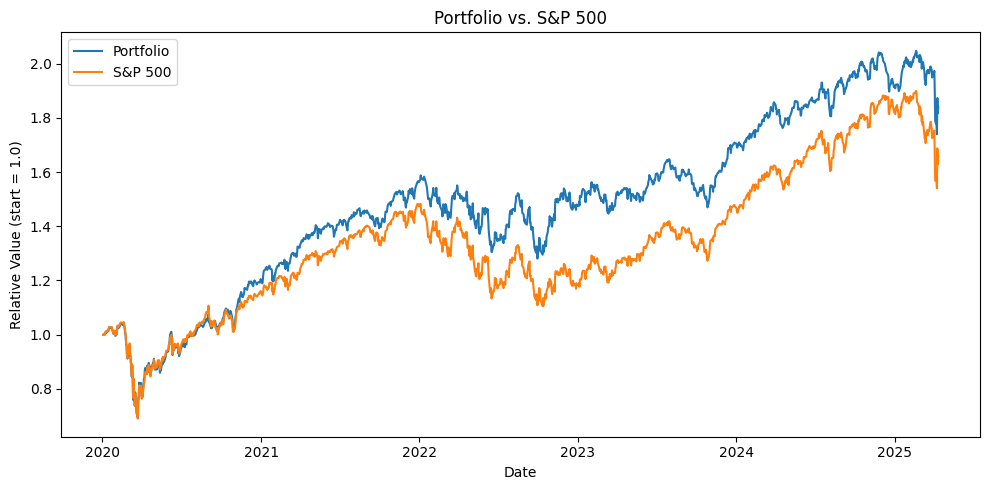

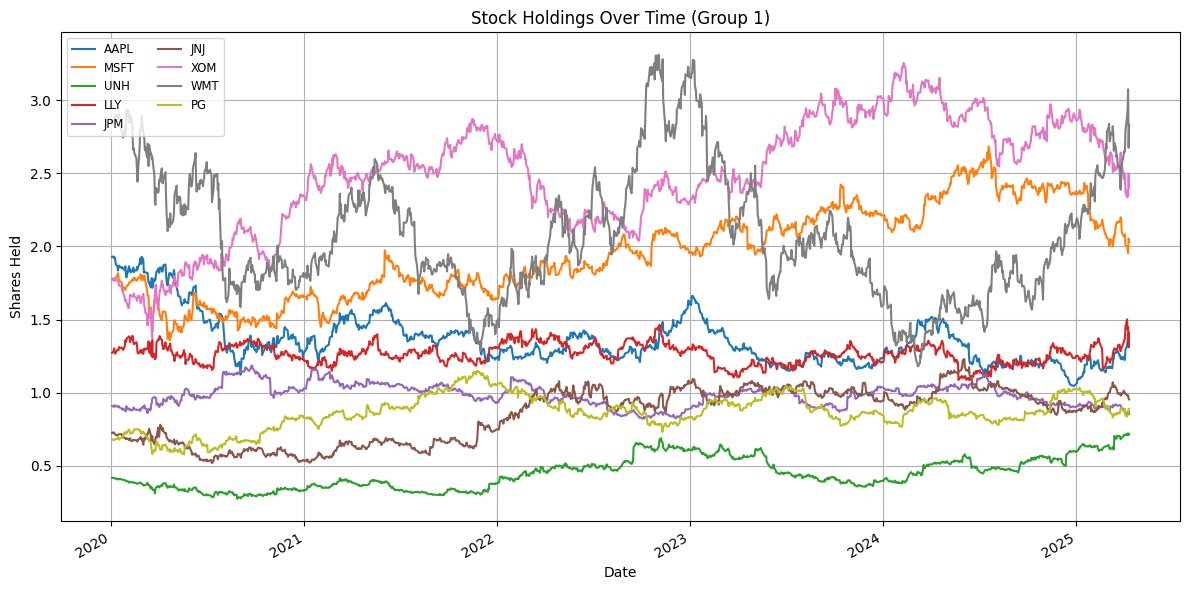

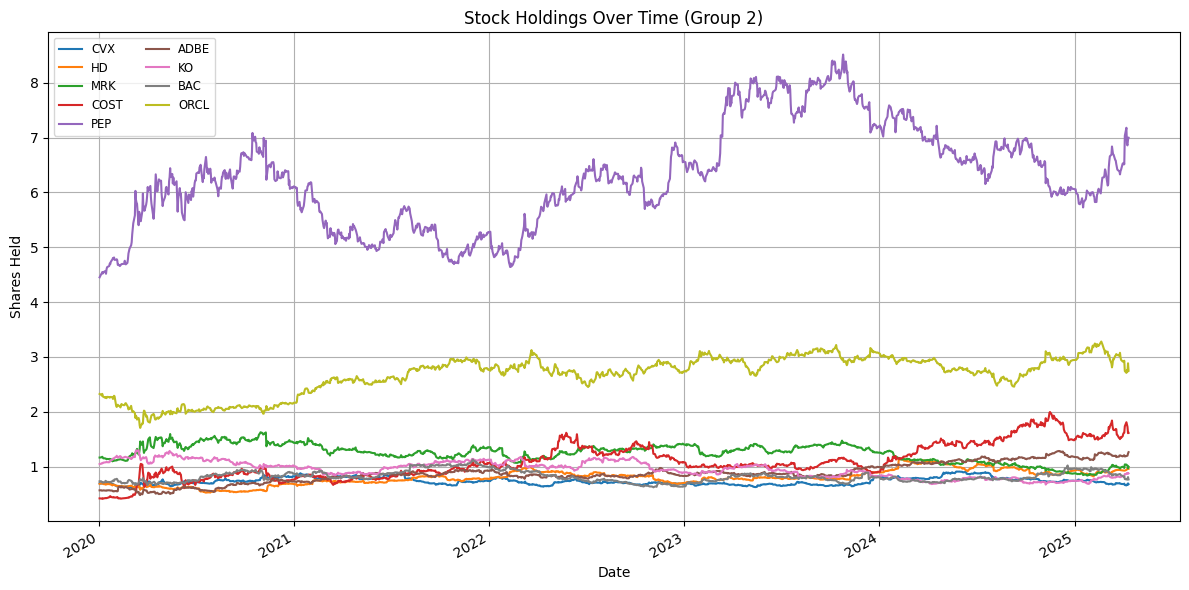

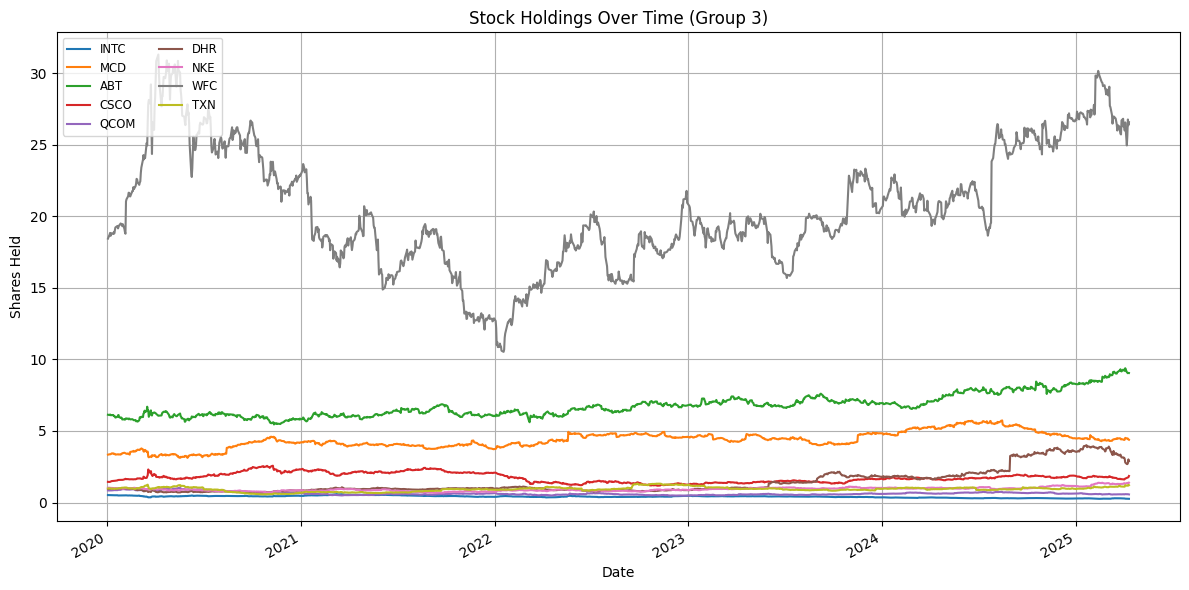

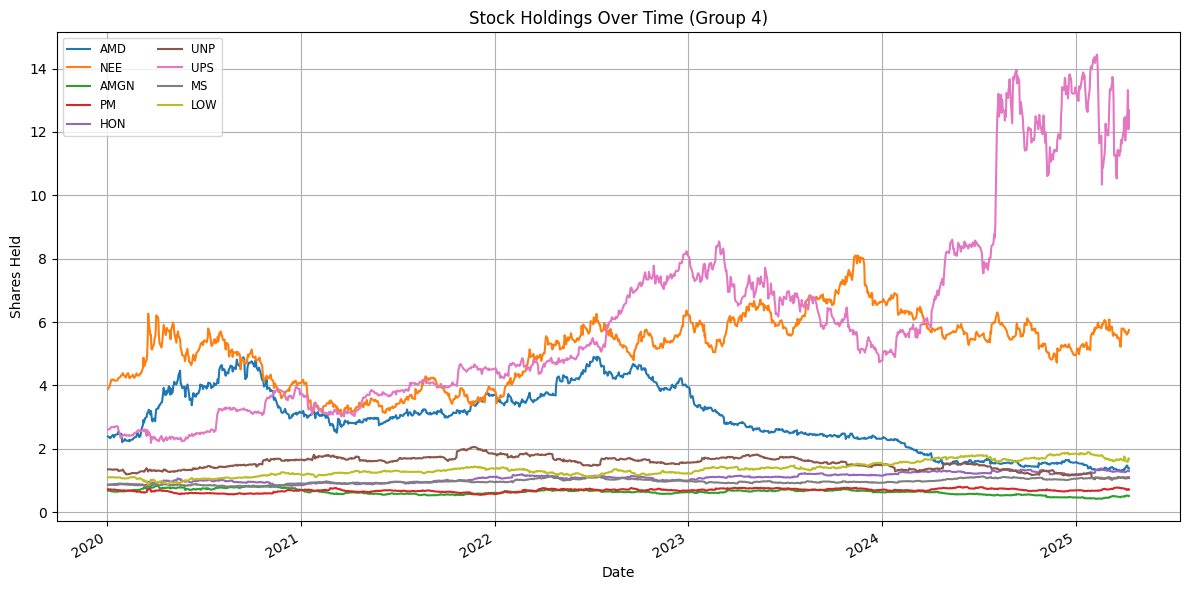

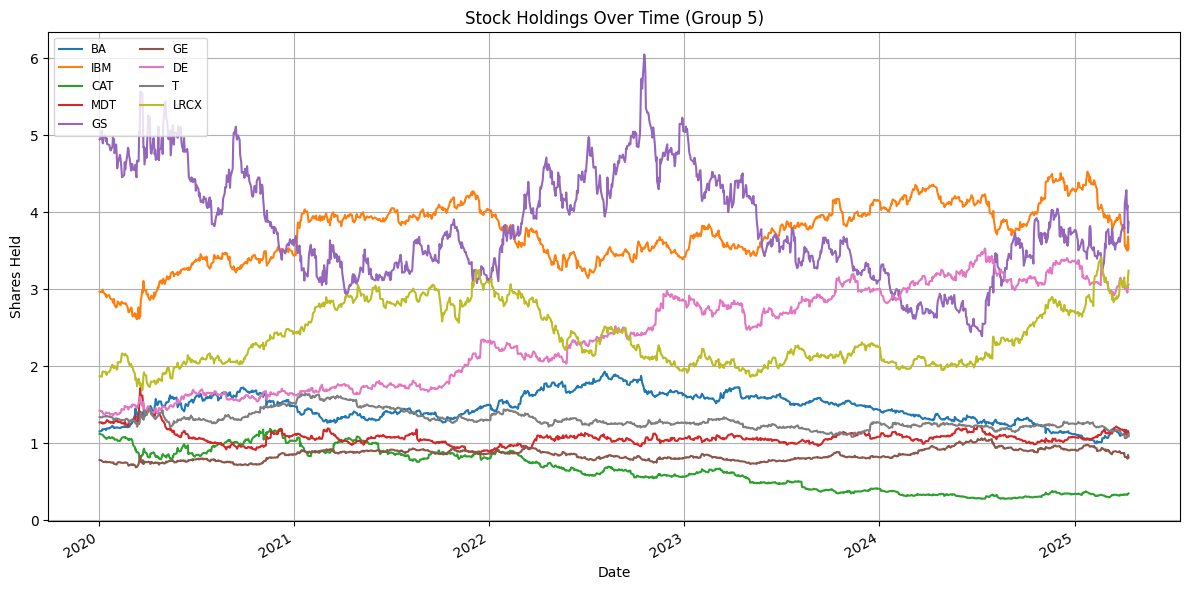

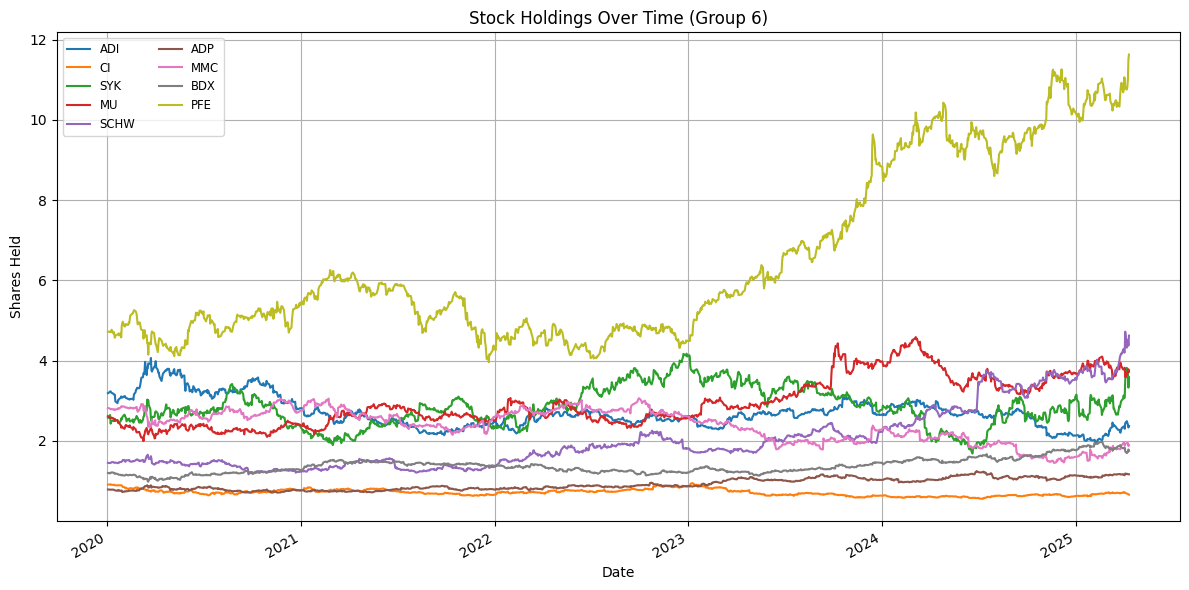

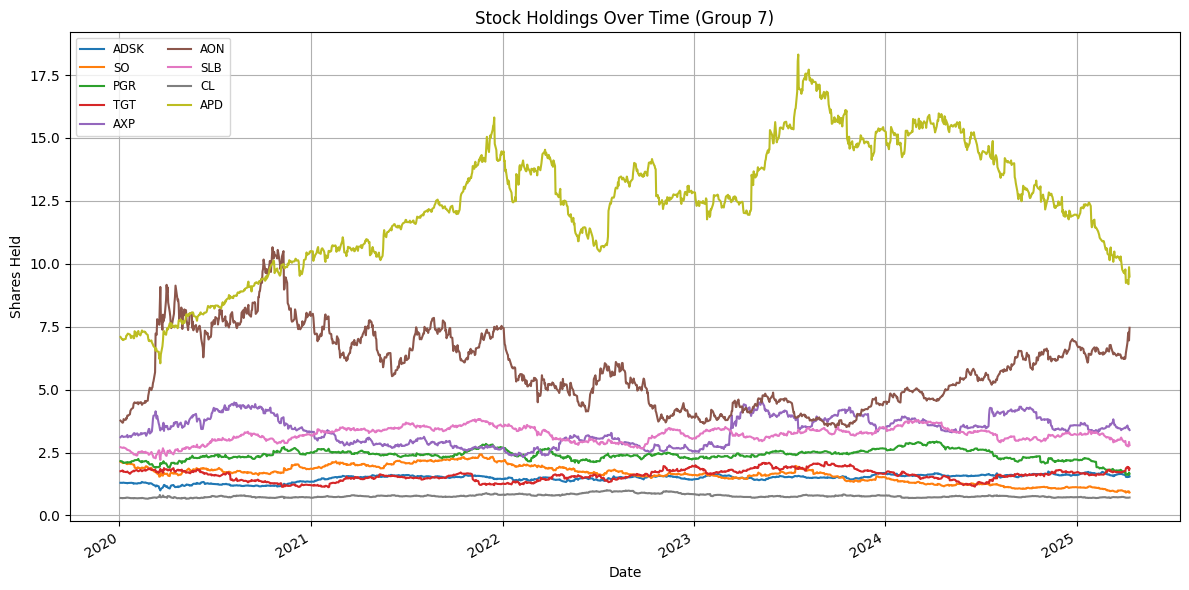

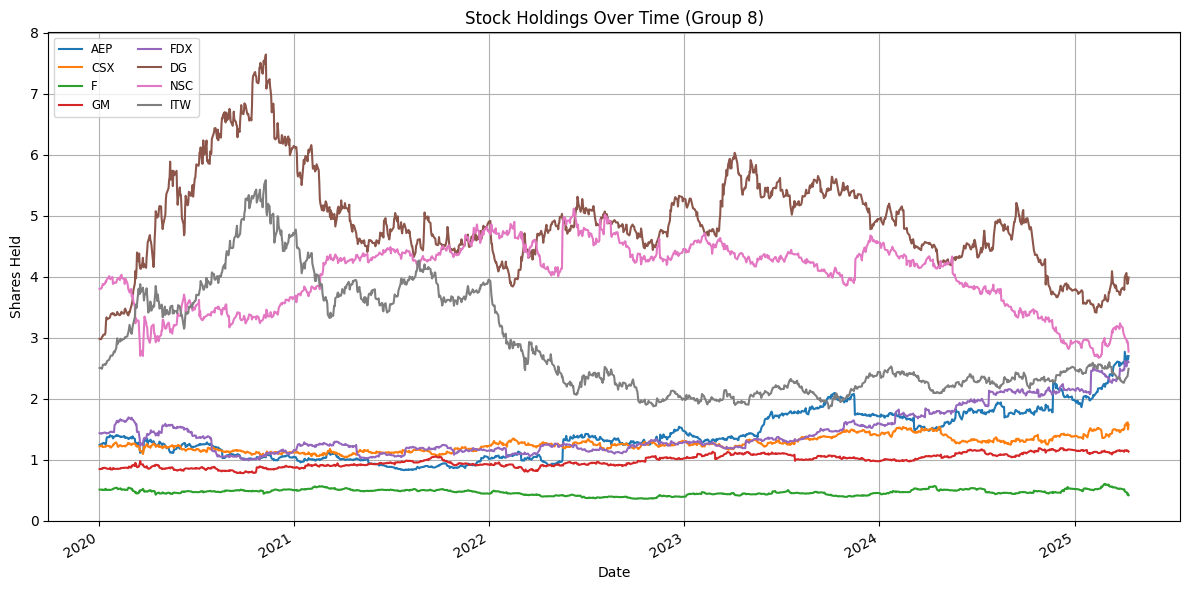

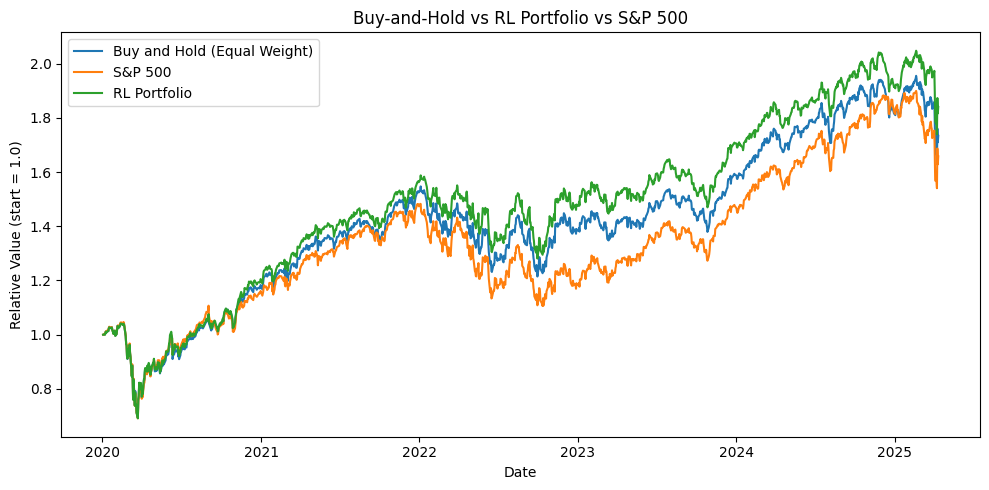

In [34]:
evaluate_agent(agent, tickers, start_date='2020-01-01', end_date='2025-04-14')


[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  1 of 1 completed
/scratch/4637934.1.l40s/ipykernel_3632764/773053045.py:263: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Benchmark (S&P500) Return: {float(bench_return):.2f}%")


Evaluation from 2020-01-02 to 2025-04-11
Portfolio Cumulative Return: 73.20%
Benchmark (S&P500) Return: 65.80%


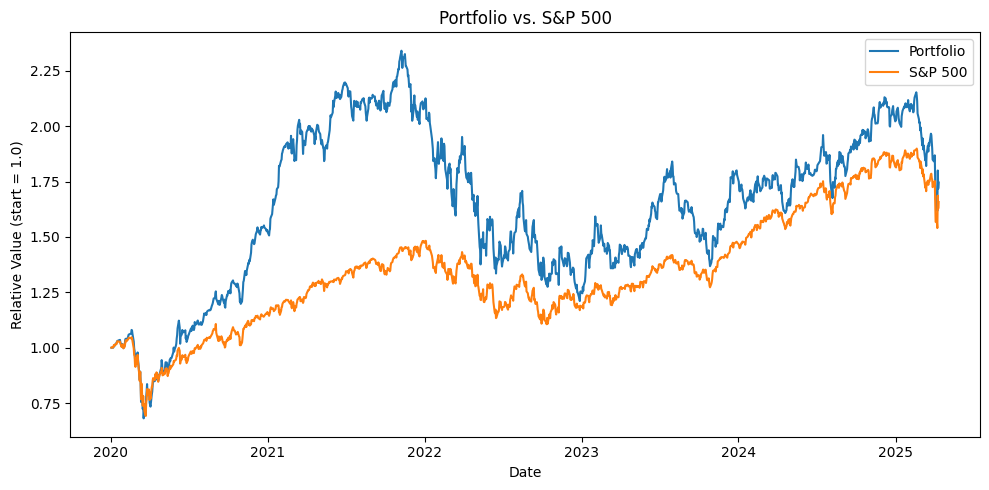

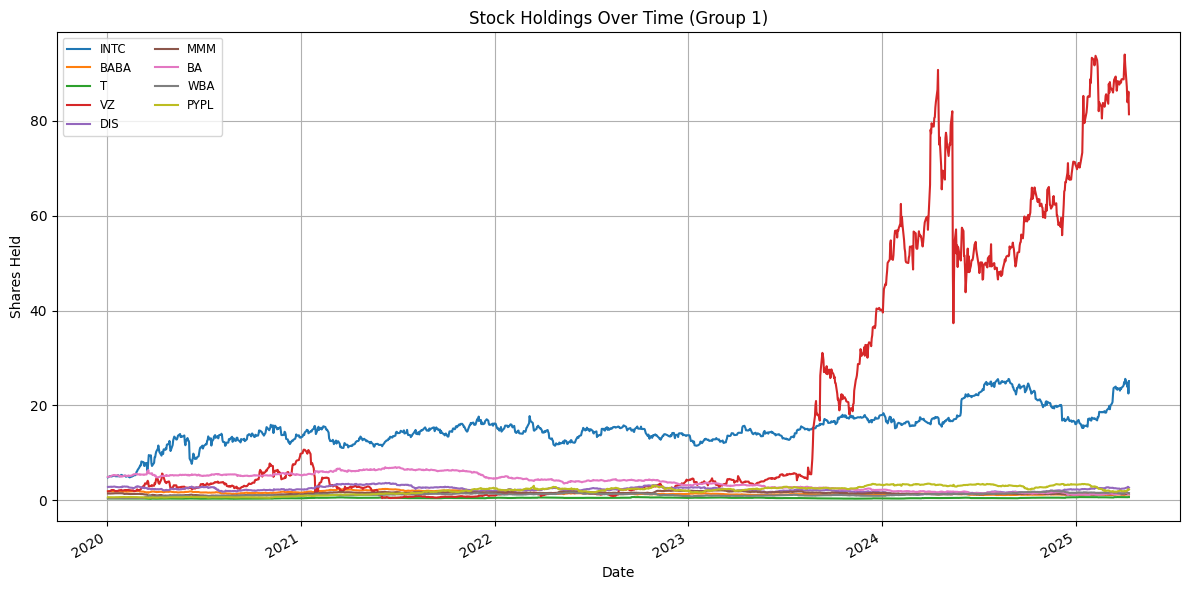

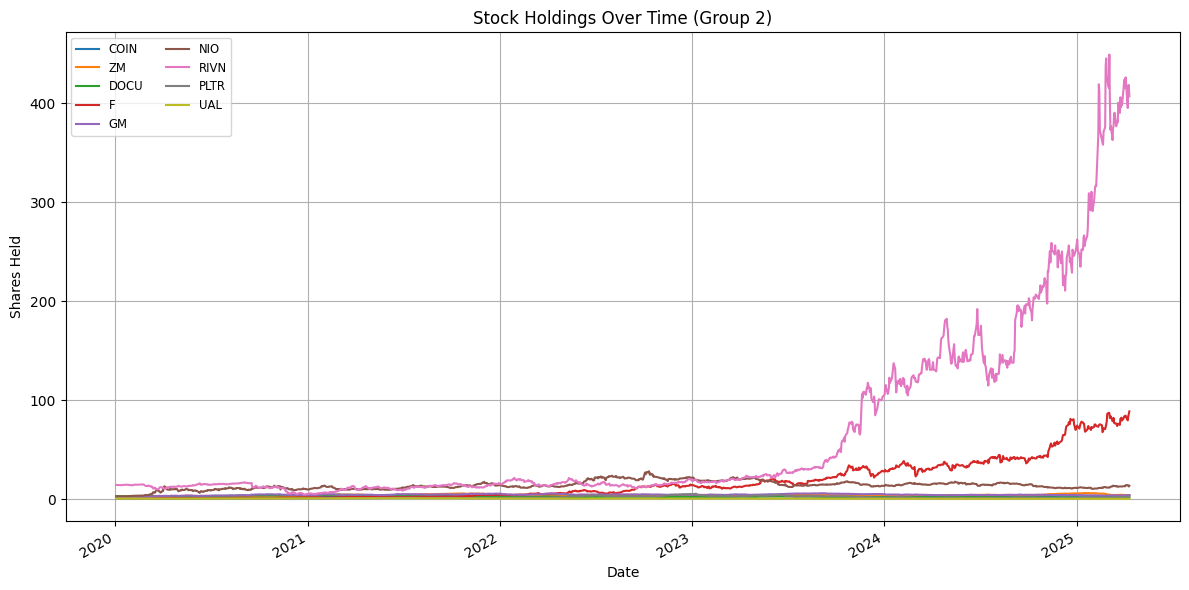

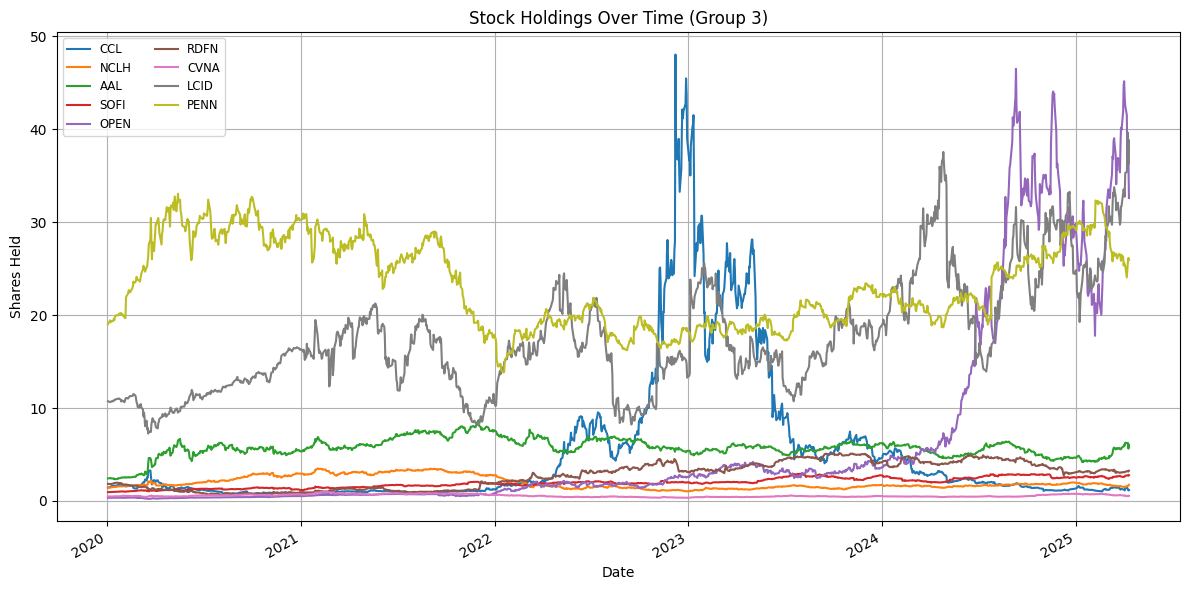

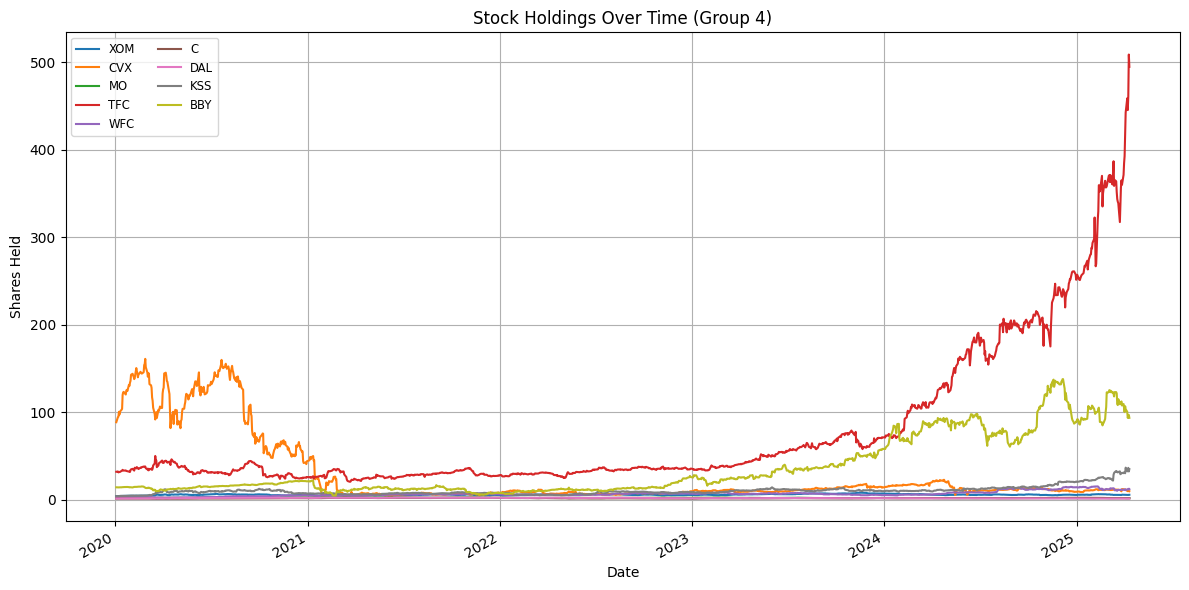

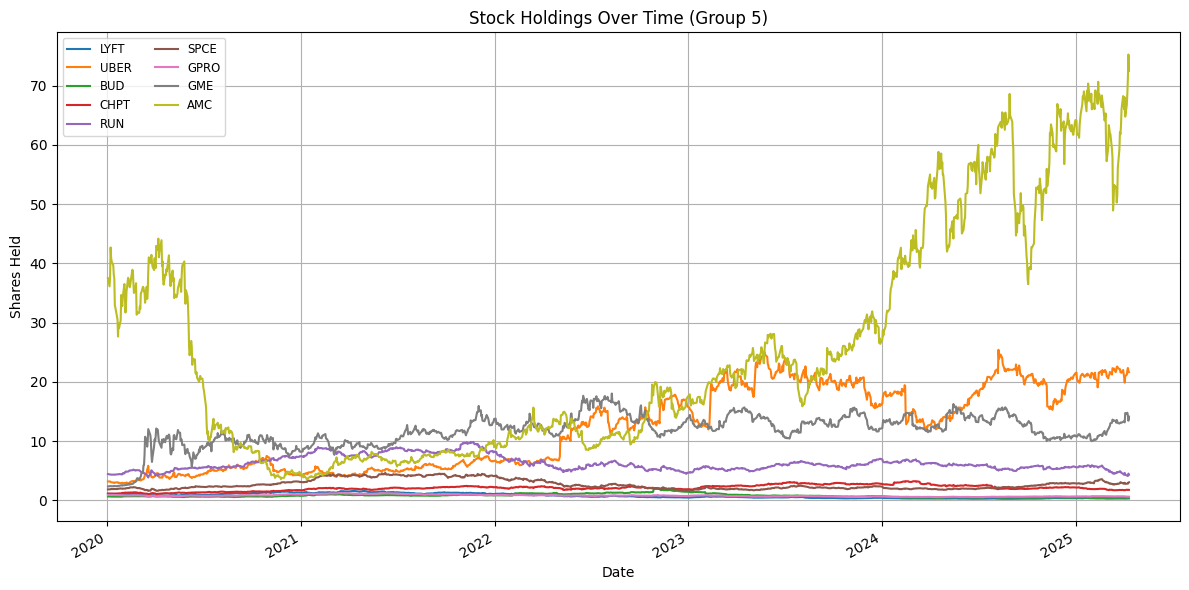

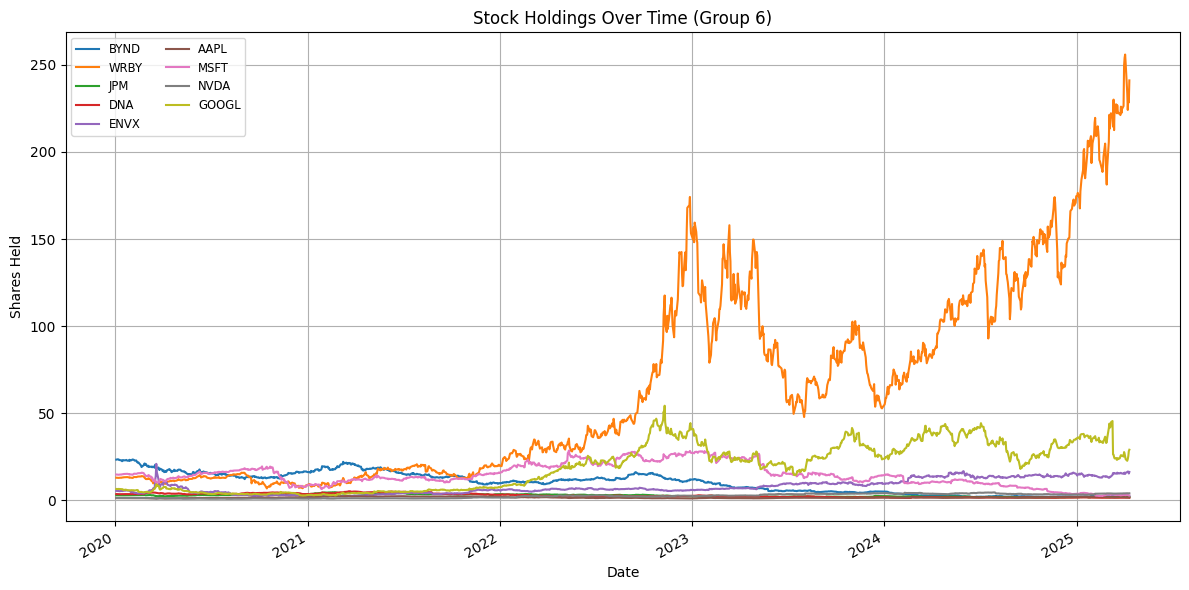

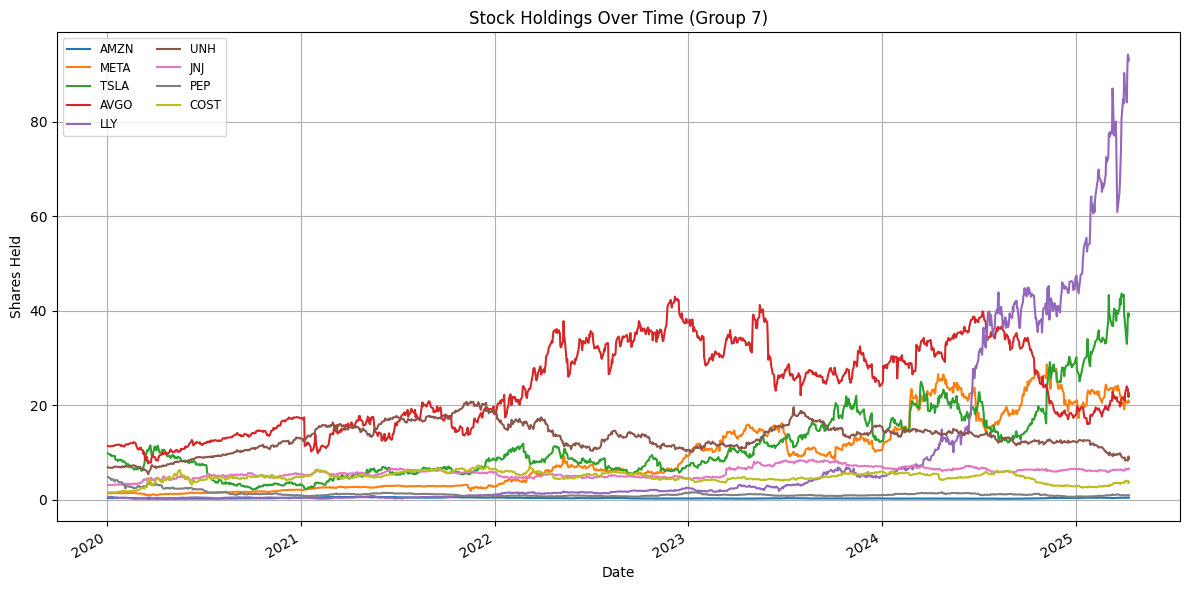

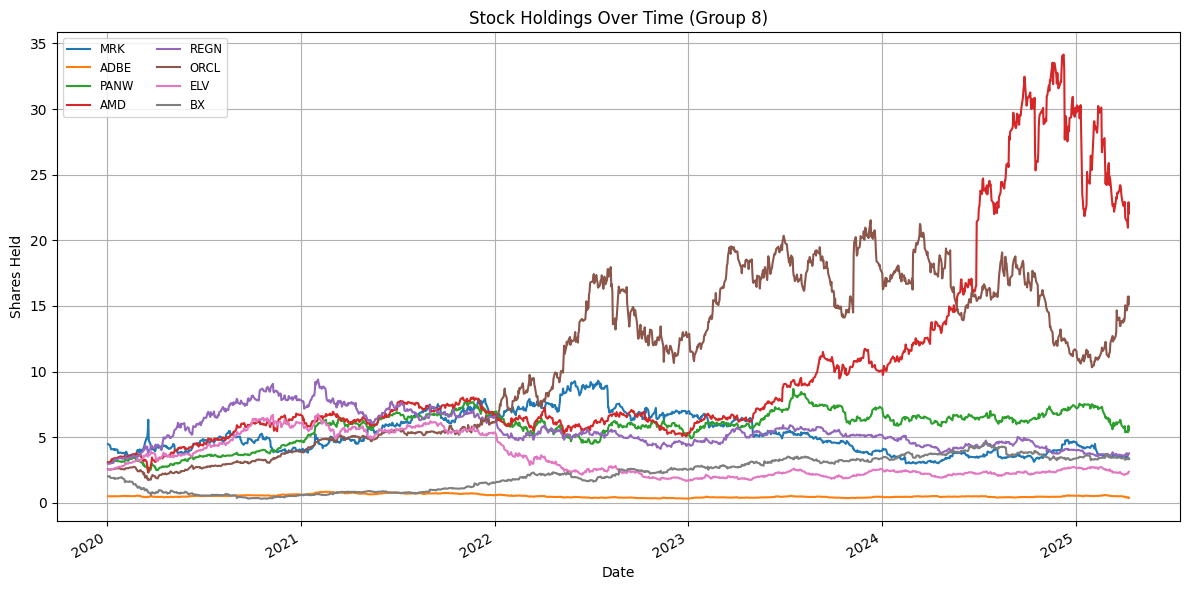

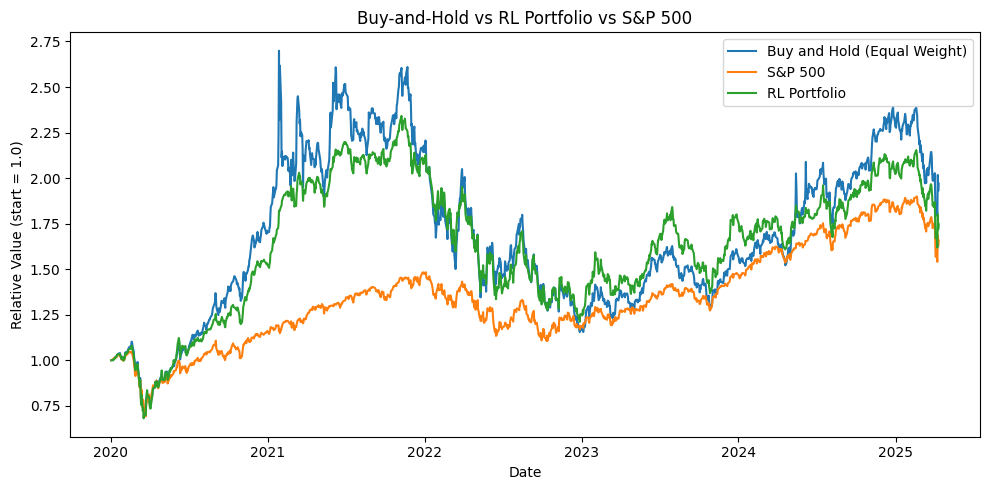

In [35]:
evaluate_agent(agent, extra_test_vals, start_date='2020-01-01', end_date='2025-04-14')


[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  1 of 1 completed
/scratch/4637934.1.l40s/ipykernel_3632764/773053045.py:263: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Benchmark (S&P500) Return: {float(bench_return):.2f}%")


Evaluation from 2020-01-02 to 2025-04-11
Portfolio Cumulative Return: 51.10%
Benchmark (S&P500) Return: 65.80%


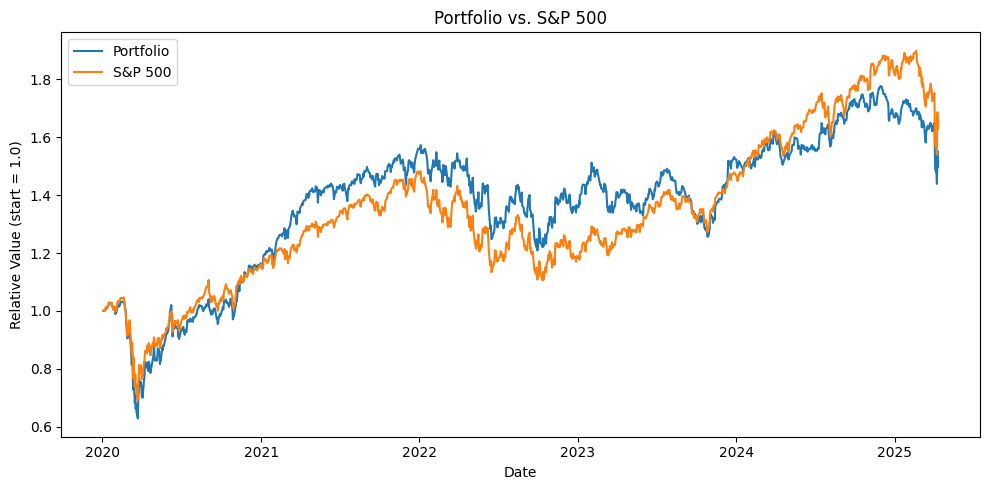

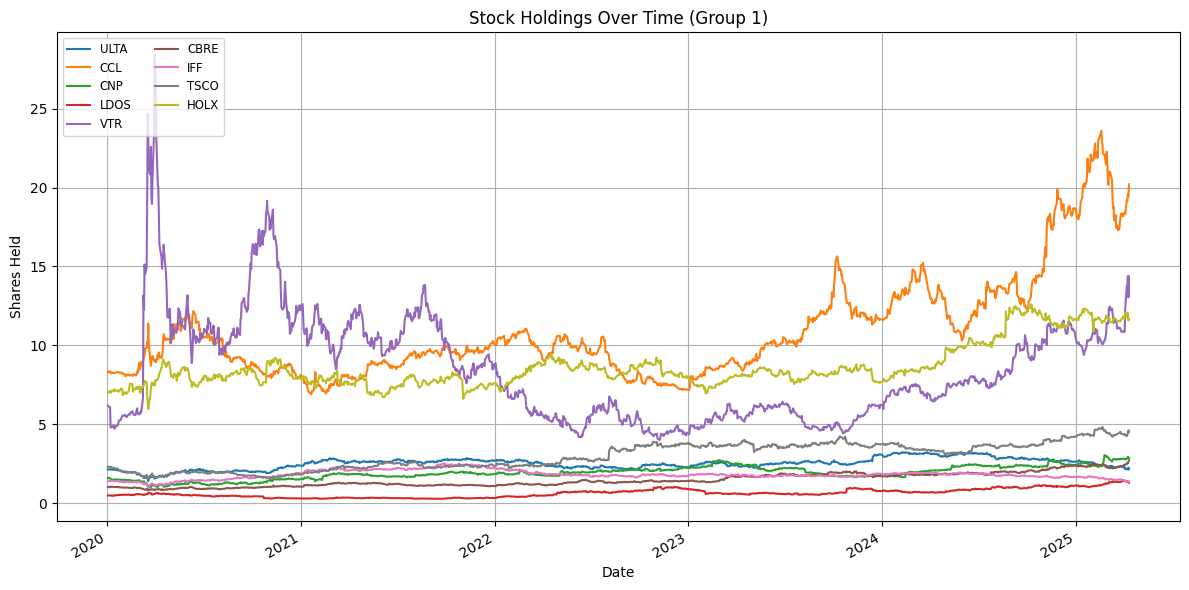

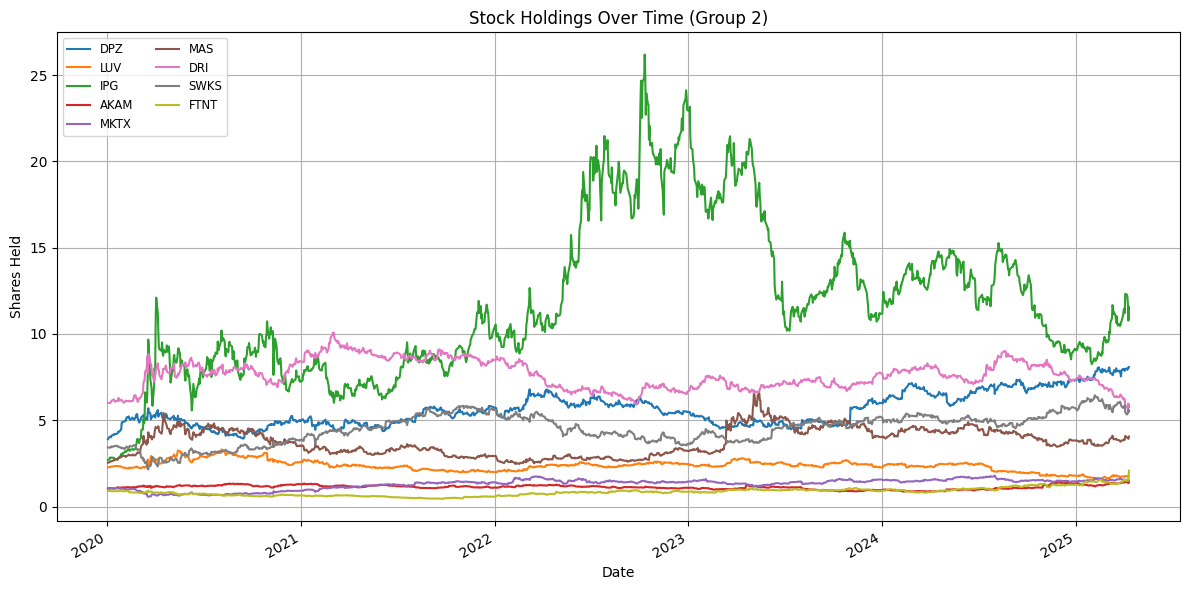

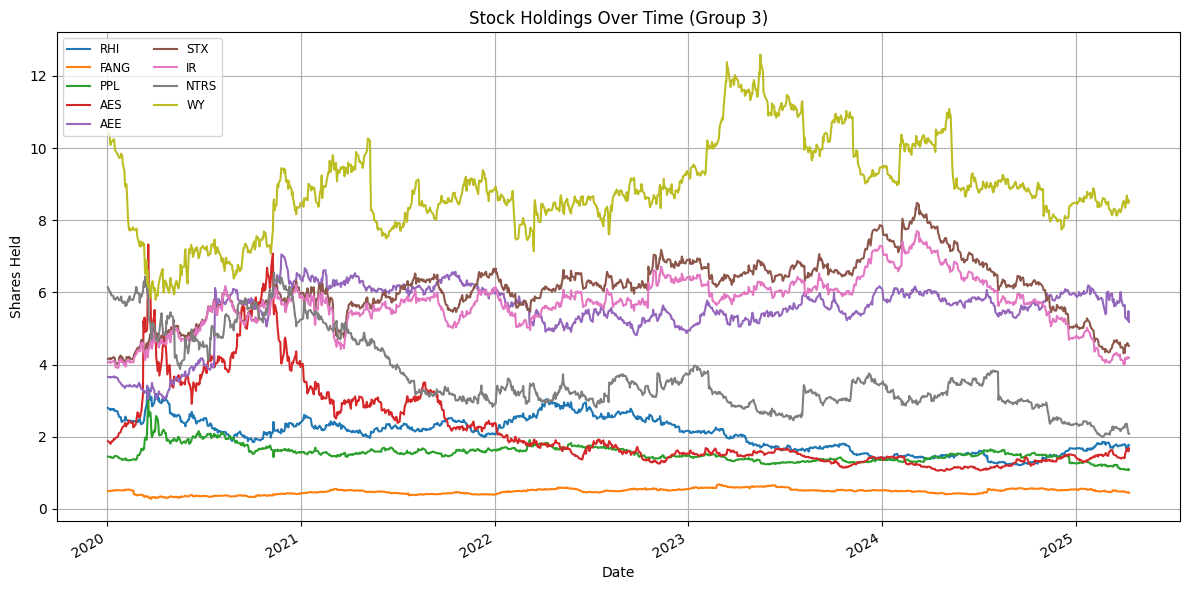

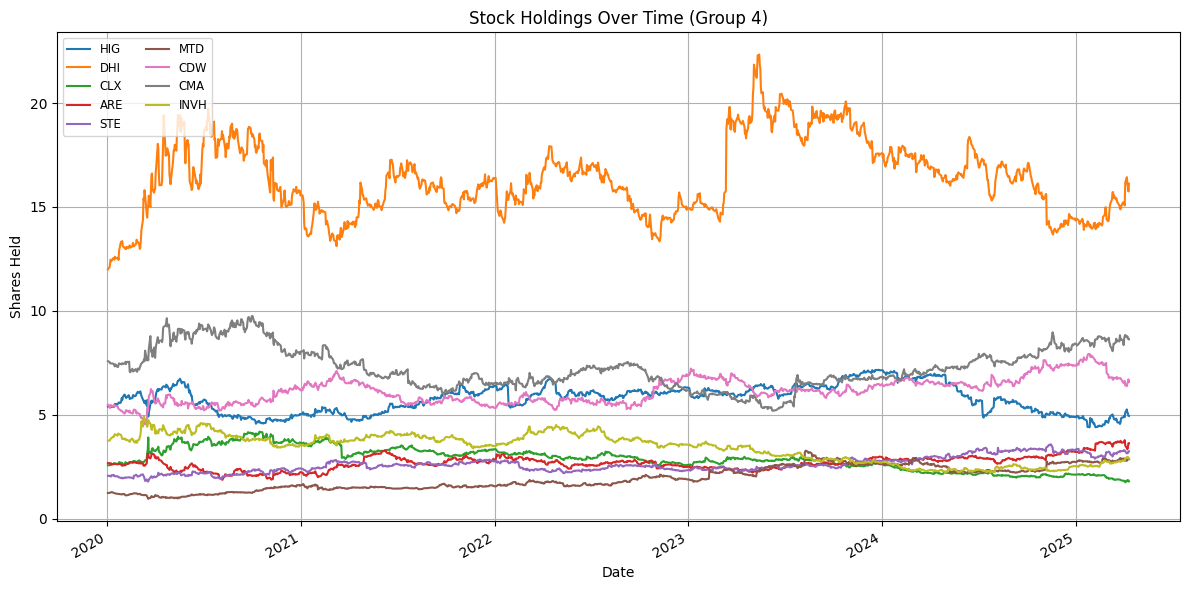

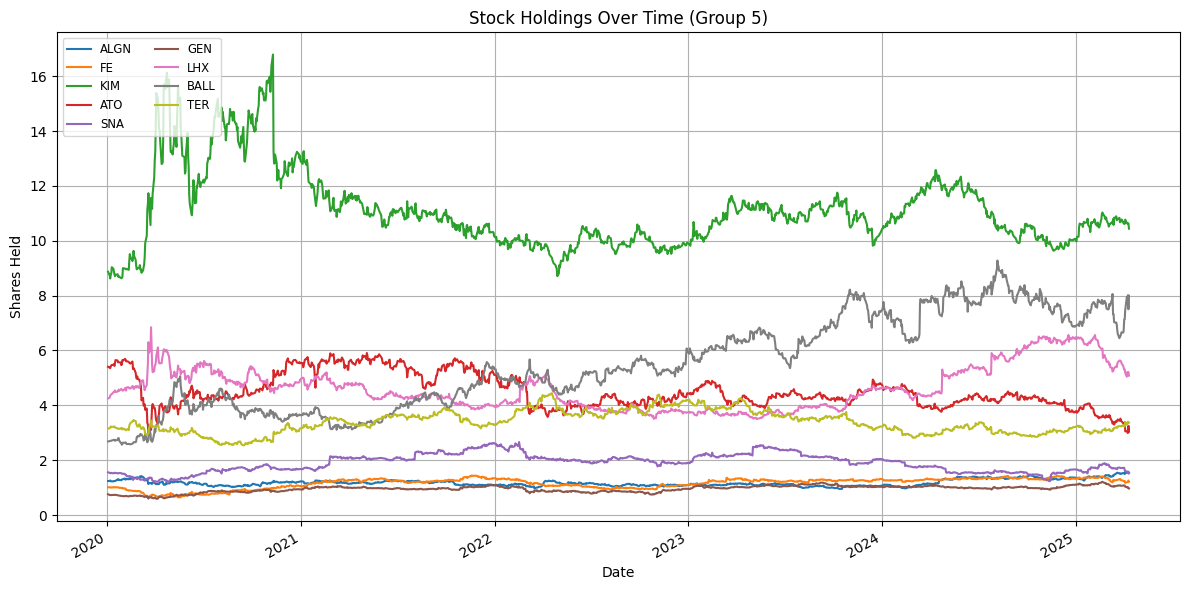

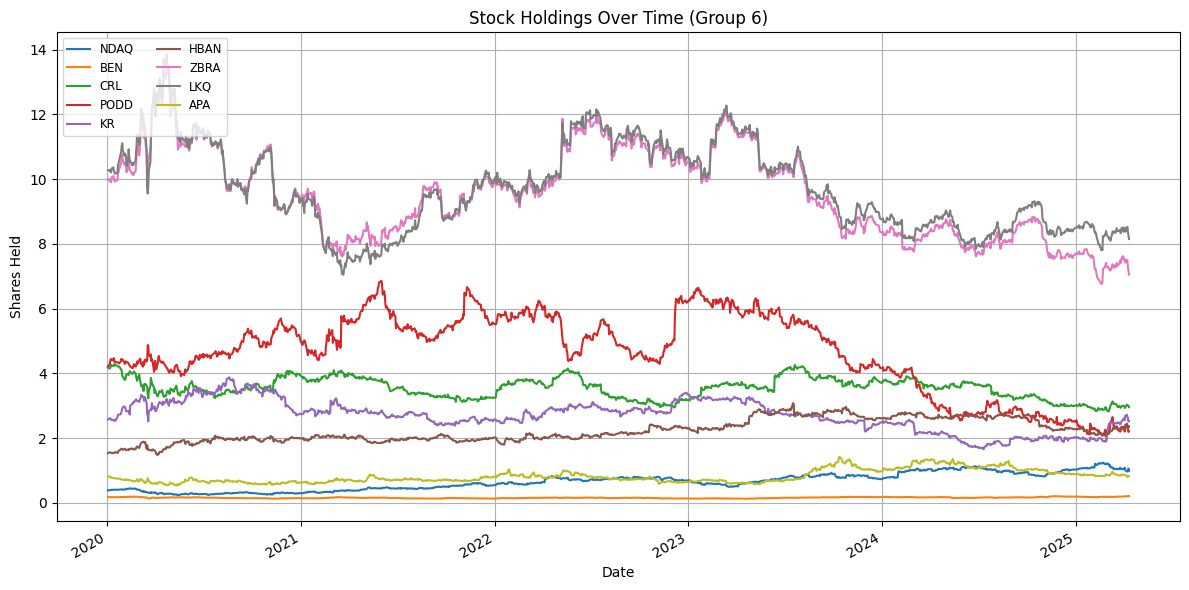

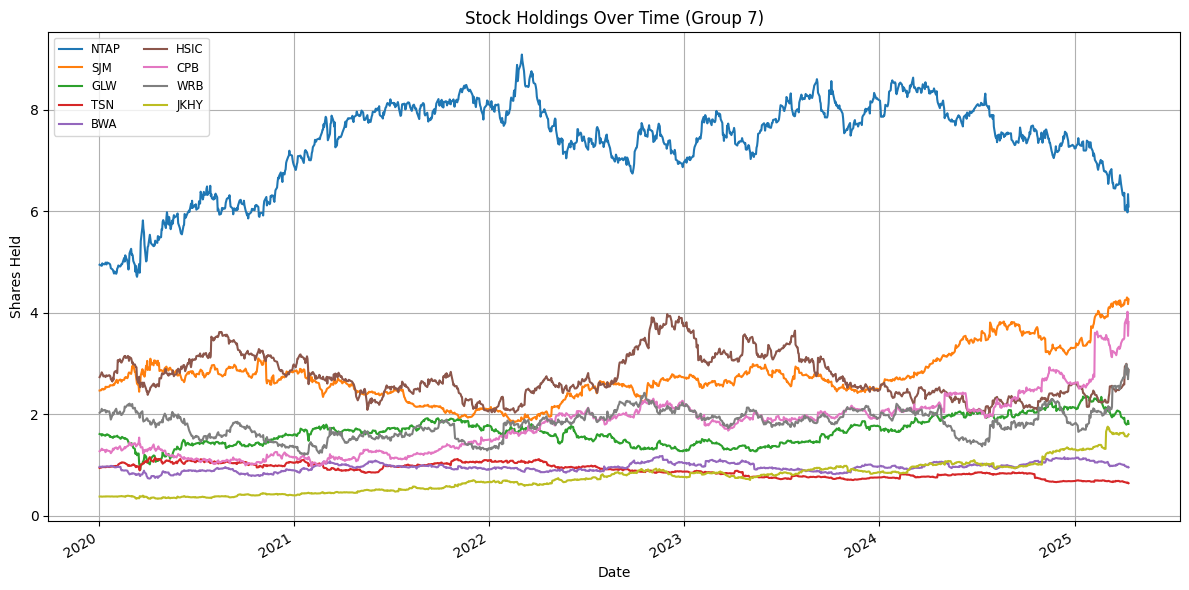

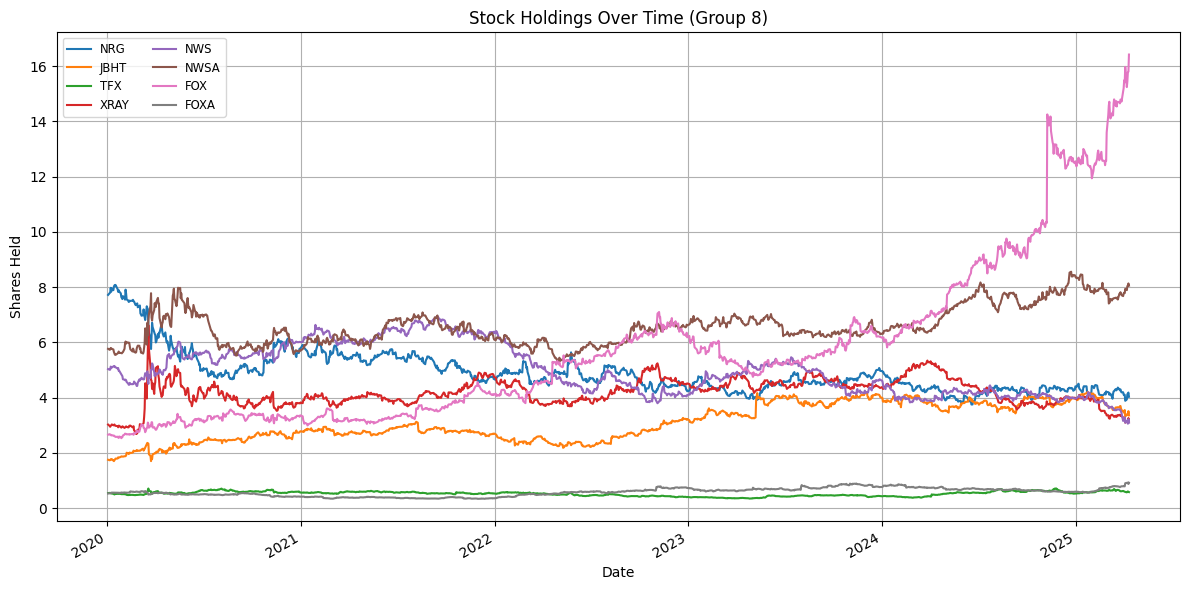

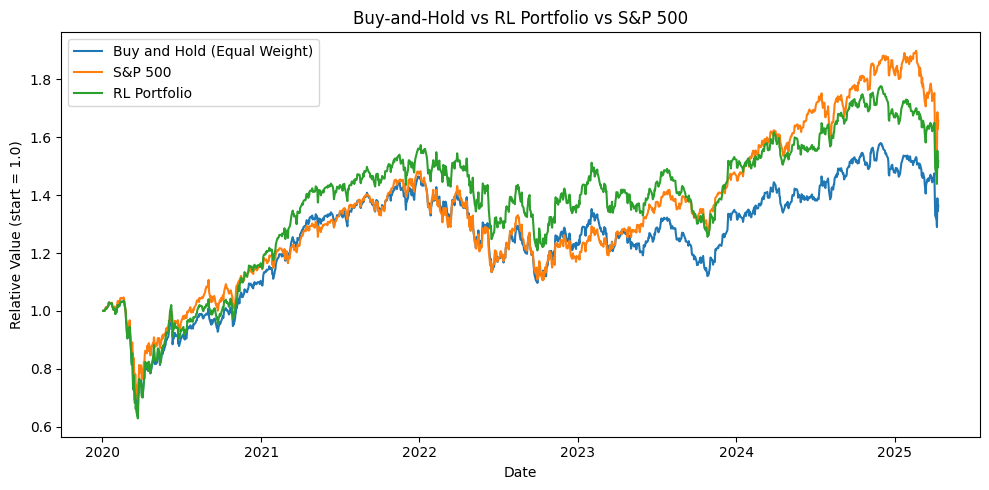

In [36]:
last = ["ULTA", "CCL", "CNP", "LDOS", "VTR", "CBRE", "IFF", "TSCO", 
 "HOLX", "DPZ", "LUV", "IPG", "AKAM", "MKTX", "MAS", "DRI", "SWKS", "FTNT", "RHI",
    "FANG", "PPL", "AES", "AEE", "STX", "IR", "NTRS", "WY", "HIG", "DHI",
    "CLX", "ARE", "STE", "MTD", "CDW", "CMA", "INVH", "ALGN", "FE", "KIM",
    "ATO", "SNA", "GEN", "LHX", "BALL", "TER", "NDAQ", "BEN", "CRL", "PODD", "KR",
    "HBAN", "ZBRA", "LKQ", "APA", "NTAP", "SJM", "GLW", "TSN", "BWA", "HSIC", "CPB",
    "WRB", "JKHY", "NRG", "JBHT", "TFX", "XRAY", "NWS", "NWSA", "FOX", "FOXA"]
evaluate_agent(agent, last, start_date='2020-01-01', end_date='2025-04-14')
